### **Import dependencies**

In [3]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomRotation,RandomZoom,RandomContrast,RandomWidth,RandomHeight

In [4]:
tf.__version__

'2.15.0'

### **Remove undesired images**

In [5]:
import cv2
import imghdr #To check the file extention

In [4]:
data_dir='/content/drive/MyDrive/mood_dataset/data'

### **Remove unwanted file extentions and small sized images**

In [8]:
image_exts=['jpeg','jpg','bmp','png']

In [9]:
from logging import exception
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,image_class)):
    image_path = os.path.join(data_dir,image_class,image)
    try:
      img=cv2.imread(image_path)
      ext=imghdr.what(image_path)
      size= os.path.getsize(image_path)/1024
      if ext not in image_exts:
        print(f"Image not in ext list {image_path}")
        os.remove(image_path)
      elif size<= 9:
        print(f"Image is too small {image_path}")
        os.remove(image_path)
    except exception as e:
      print(f"Issue with an image {image_path}")


### **Load** **Data**

In [5]:

IMG_SIZE = (224,224)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=16
)


validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=16
)

Found 177 files belonging to 2 classes.
Using 142 files for training.
Found 177 files belonging to 2 classes.
Using 35 files for validation.


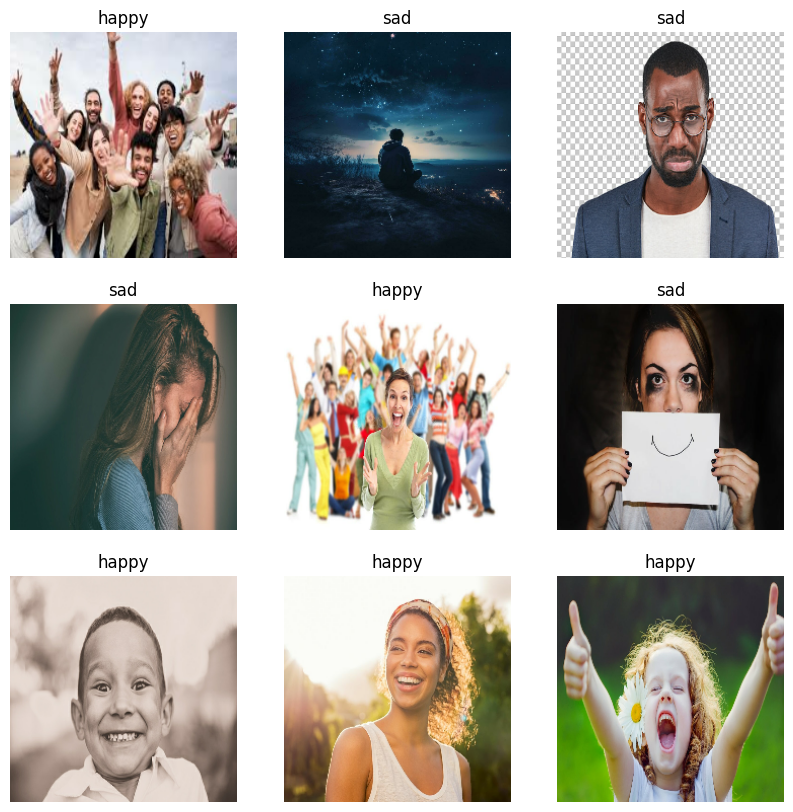

In [6]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint32"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches // 2)
# validation_dataset = validation_dataset.skip(val_batches // 2)

In [10]:

print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_dataset)}")
# print(f"Number of test batches: {tf.data.experimental.cardinality(test_dataset)}")

Number of validation batches: 3


### **Data Augmentation for the Training data**

In [6]:
def data_augmenter():
    """
      creates a sequential model to augment data
    """
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.8))
    data_augmentation.add(RandomZoom(0.2))
    data_augmentation.add(RandomContrast(0.2))
    # data_augmentation.add(RandomHeight(0.2))
    # data_augmentation.add(RandomWidth(0.2))
    return data_augmentation

data_augmentation = data_augmenter()

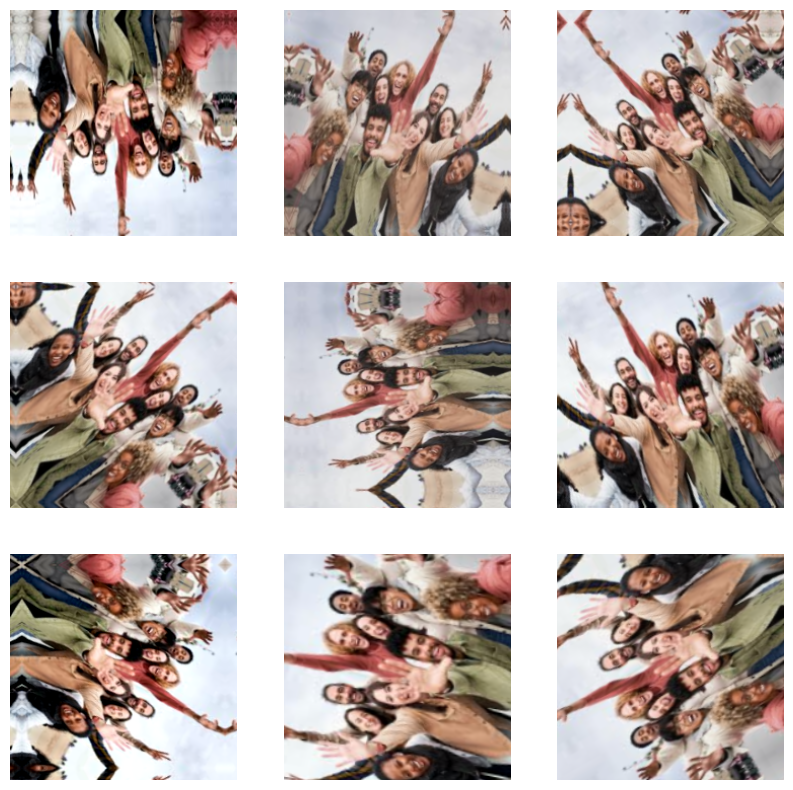

In [6]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) ##adds the batch dimension as the keras is expecting a batch
        plt.imshow(augmented_image[0]/255) #remove the batch dimension and normalize the data between [0,1]
        plt.axis('off')

### **Prepare the dataset for performance**

In [7]:
# Prepare datasets for performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

### **Applying the augmentation to the Training dataset**

In [8]:
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))


### **Normalize Data**

In [9]:
from tensorflow.keras import layers

# Normalize data
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
# test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

Text(0.5, 1.0, 'Image after denormalization')

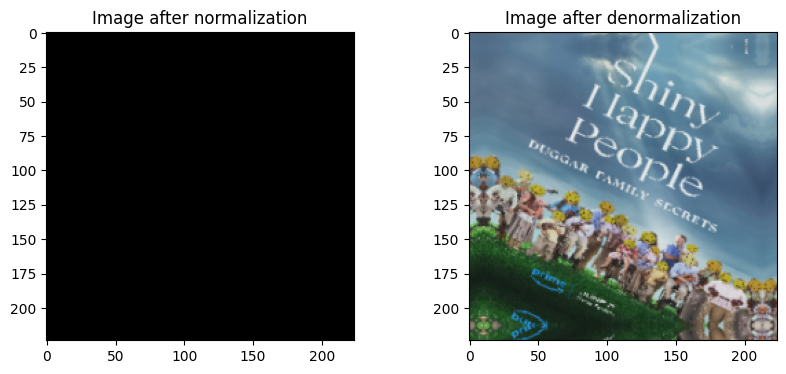

In [10]:
images, labels = next(iter(train_dataset))
# image_to_display = images[5].numpy()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(images[8].numpy().astype(np.uint8));
plt.title("Image after normalization")
plt.subplot(1,2,2)
plt.imshow((images[8].numpy()*255).astype(np.uint8));
plt.title("Image after denormalization")

### **Simple Sequential CNN model**

In [21]:
from keras.models import Sequential
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization
from keras.losses import BinaryCrossentropy

def create_model(learning_rate=1e-4, dropout_rate=0.5, lamda=0.1):
    model_1 = Sequential(name="Simple_Sequential_model")

    model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model_1.add(BatchNormalization())
    model_1.add(MaxPooling2D((2, 2)))

    model_1.add(Conv2D(64, (3, 3), activation='relu'))
    model_1.add(BatchNormalization())
    model_1.add(MaxPooling2D((2, 2)))

    model_1.add(Conv2D(128, (3, 3), activation='relu'))
    model_1.add(MaxPooling2D((2, 2)))

    model_1.add(Flatten())
    model_1.add(Dense(256, activation="relu", kernel_regularizer=l2(lamda)))
    model_1.add(Dropout(dropout_rate))
    model_1.add(BatchNormalization())
    model_1.add(Dense(128, activation="relu", kernel_regularizer=l2(lamda)))
    model_1.add(Dropout(dropout_rate))
    # model_1.add(Dense(64, activation="relu", kernel_regularizer=l2(lamda)))
    # model_1.add(Dropout(dropout_rate))
    model_1.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(learning_rate=learning_rate)
    model_1.compile(optimizer=optimizer, loss=BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
    return model_1

### **Random Search for hyper parameter tunning**

In [23]:
# Function to convert TensorFlow dataset to NumPy arrays
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image, label in dataset.as_numpy_iterator():
        images.append(image)
        labels.append(label)
    return np.concatenate(images, axis=0), np.concatenate(labels, axis=0)

In [20]:

# Convert train and validation datasets to NumPy arrays
X_train, y_train = dataset_to_numpy(train_dataset)
X_val, y_val = dataset_to_numpy(validation_dataset)

In [42]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
model_1 = KerasClassifier(model=lambda learning_rate=1e-3, dropout_rate=0.5, lamda=0.01: create_model(learning_rate, dropout_rate, lamda), verbose=1)



In [43]:
param_dist = {
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'dropout_rate': [0.3, 0.4, 0.5],
    'batch_size': [16, 32],
    'lamda':[0.1,0.01,0.001],
    'epochs':[10]
}

In [44]:

random_search = RandomizedSearchCV(estimator=model_1,
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   n_jobs=1,
                                   cv=3)


In [46]:
print(model_1.get_params().keys())


dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'class_weight'])


In [48]:
# random_search_result = random_search.fit(X_train, y_train, validation_data=(X_val, y_val))

In [ ]:
best_model = random_search_result.best_estimator_.model

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


In [22]:
model_1= create_model()
history_1=model_1.fit(train_dataset,validation_data=validation_dataset,epochs=30,callbacks=[early_stopping])

Epoch 1/30
9/9 [==============================] - 4s 196ms/step - loss: 66.1623 - accuracy: 0.5915 - val_loss: 62.8587 - val_accuracy: 0.5143
Epoch 2/30
9/9 [==============================] - 2s 257ms/step - loss: 60.1865 - accuracy: 0.6901 - val_loss: 56.8599 - val_accuracy: 0.6000
Epoch 3/30
9/9 [==============================] - 2s 220ms/step - loss: 54.1431 - accuracy: 0.6620 - val_loss: 51.0523 - val_accuracy: 0.6571
Epoch 4/30
9/9 [==============================] - 2s 195ms/step - loss: 48.6550 - accuracy: 0.6549 - val_loss: 45.8123 - val_accuracy: 0.7429
Epoch 5/30
9/9 [==============================] - 2s 170ms/step - loss: 43.5322 - accuracy: 0.7746 - val_loss: 41.2182 - val_accuracy: 0.5429
Epoch 6/30
9/9 [==============================] - 2s 173ms/step - loss: 39.2733 - accuracy: 0.7183 - val_loss: 37.2663 - val_accuracy: 0.4857
Epoch 7/30
9/9 [==============================] - 2s 173ms/step - loss: 35.5644 - accuracy: 0.7606 - val_loss: 33.8928 - val_accuracy: 0.4857
Epoch 

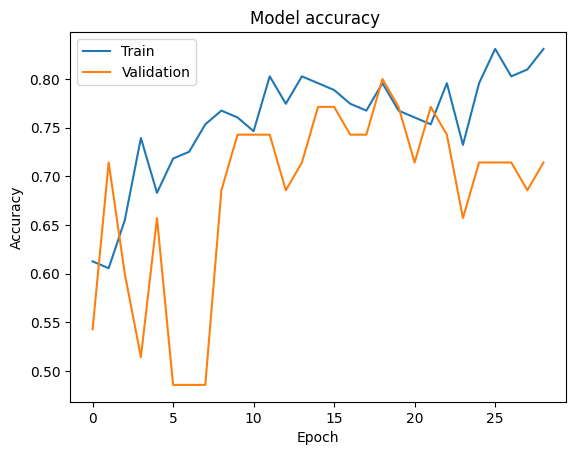

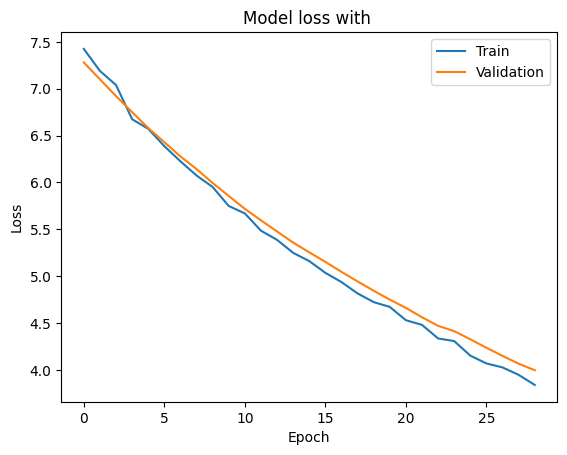

In [16]:
# Plot training & validation accuracy values
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot training & validation loss values
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss with ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

### **Transfer learning**

In [29]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

transfer_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu',kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    # Dense(128, activation='relu',kernel_regularizer=l2(0.001)),
    # Dropout(0.4),
    Dense(2, activation='softmax')
])

transfer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [ ]:

history_transfer = transfer_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)

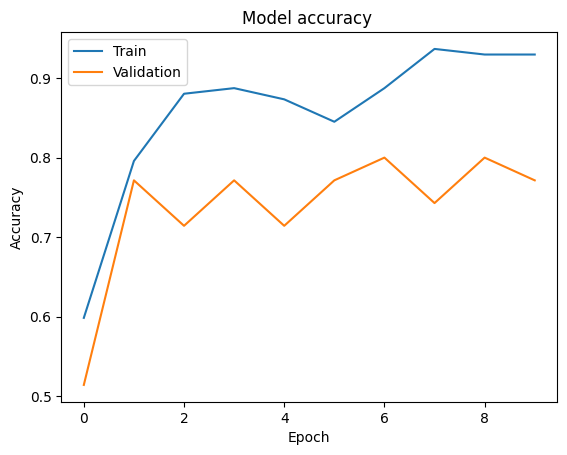

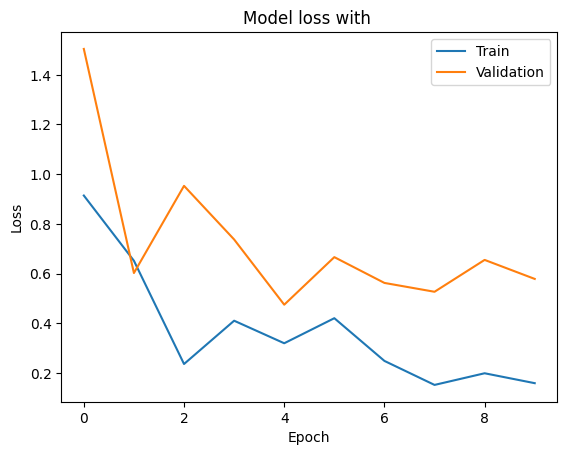

In [14]:
# Plot training & validation accuracy values
plt.plot(history_transfer.history['accuracy'])
plt.plot(history_transfer.history['val_accuracy'])
plt.title('Model accuracy ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot training & validation loss values
plt.plot(history_transfer.history['loss'])
plt.plot(history_transfer.history['val_loss'])
plt.title('Model loss with ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

### **Transfer Learning with fine tunnnig**

In [30]:
base_model.trainable = True
# Fine-tuning specific layers
fine_tune_at = 100  # Unfreeze all layers after layer 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate
                       loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_fine_tune = transfer_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30
)

Epoch 1/30
9/9 [==============================] - 21s 1s/step - loss: 1.6784 - accuracy: 0.4648 - val_loss: 1.5235 - val_accuracy: 0.4857
Epoch 2/30
9/9 [==============================] - 11s 1s/step - loss: 1.5614 - accuracy: 0.5634 - val_loss: 1.4658 - val_accuracy: 0.5143
Epoch 3/30
9/9 [==============================] - 11s 1s/step - loss: 1.5626 - accuracy: 0.5000 - val_loss: 1.4285 - val_accuracy: 0.6286
Epoch 4/30
9/9 [==============================] - 12s 1s/step - loss: 1.4555 - accuracy: 0.6268 - val_loss: 1.3971 - val_accuracy: 0.6857
Epoch 5/30
9/9 [==============================] - 11s 1s/step - loss: 1.3960 - accuracy: 0.6268 - val_loss: 1.3750 - val_accuracy: 0.7143
Epoch 6/30
9/9 [==============================] - 12s 1s/step - loss: 1.2935 - accuracy: 0.7465 - val_loss: 1.3628 - val_accuracy: 0.7143
Epoch 7/30
9/9 [==============================] - 11s 1s/step - loss: 1.3448 - accuracy: 0.6549 - val_loss: 1.3491 - val_accuracy: 0.6857
Epoch 8/30
9/9 [==================

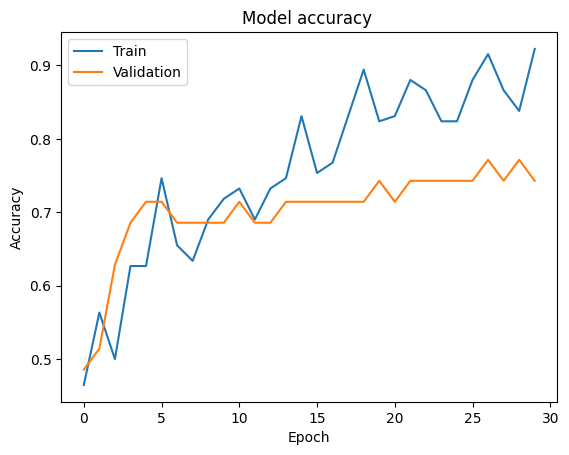

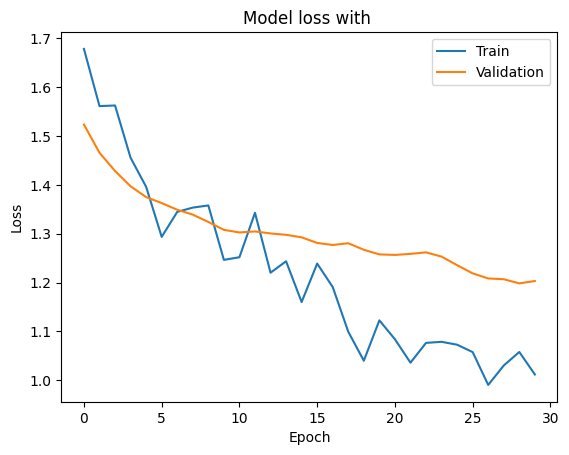

In [31]:
# Plot training & validation accuracy values
plt.plot(history_fine_tune.history['accuracy'])
plt.plot(history_fine_tune.history['val_accuracy'])
plt.title('Model accuracy ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot training & validation loss values

plt.plot(history_fine_tune.history['loss'])
plt.plot(history_fine_tune.history['val_loss'])
plt.title('Model loss with ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

### **Predictions**

In [37]:
# Path to the image you want to predict
from tensorflow.keras.preprocessing import image

img_path = "/content/drive/MyDrive/mood_dataset/test_2.jpeg"

# Load the image with the target size your model expects
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to an array
img_array = image.img_to_array(img)

# Expand dimensions to create a batch of one image
img_array = tf.expand_dims(img_array, 0)

img_array=img_array/255.0

# Make predictions on the batch
predictions = transfer_model.predict(img_array)

# Apply softmax to the logits to get probabilities
score = tf.nn.softmax(predictions[0])

# Get the class names (you should define this list based on your dataset)
class_names = ['sad','happy']  # Example class names

# Print the result
print(f"This image is {100 * np.max(score):.2f}% {class_names[np.argmax(score)]}")

1/1 [==============================] - 0s 126ms/step
This image is 56.13% sad
